**Import packages**

In [1]:
!pip install pytictoc

In [2]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
from pytictoc import TicToc
warnings.filterwarnings( "ignore" )

**Load the dataset**

In [3]:
(X_train, y_train), (X_test,y_test) = datasets.cifar10.load_data()
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000,), (10000, 32, 32, 3), (10000,))

**Create helper functions**

In [4]:
def plot_sample_image(X, y):
    plt.figure(figsize = (15,2))
    plt.imshow(X); plt.colorbar();
    classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    plt.xlabel('Image Label: {}'.format(classes[y]))

def classification_results(X_test,y_test,y_pred_classes):
  from sklearn.metrics import confusion_matrix , classification_report
  import seaborn as sn

  cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_classes)
  plt.figure(figsize = (7,5))
  sn.heatmap(cm, annot=True, fmt='d', cmap='Greens')
  plt.xlabel('Predicted');
  plt.ylabel('Truth');

  print("Classification Report: \n", classification_report(y_test, y_pred_classes))

def plot_fitting_history(history,filename,dpi):
  epochs = len(history.history['loss'])
  epoch_data = np.arange(1,epochs+1)
  plt.plot(epoch_data,history.history['loss'],'o-')
  plt.plot(epoch_data,history.history['val_loss'],'o--')
  plt.ylabel('Loss')
  plt.xlabel('Epoch sequence' )
  plt.xticks(np.arange(0, epochs + 1, step=1))
  plt.legend(['Training','Validation'])
  plt.savefig(filename, dpi=dpi)
  plt.show()

**Normalize the input data**

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

**Plot sample image**

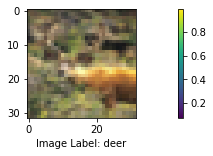

In [6]:
index = np.random.randint(100)
plot_sample_image(X_train[index], y_train[index])

In [7]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/ECE 696B/Project - ECE696B

**Load the models**

In [9]:
%cd C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B
from keras.models import load_model
Linear_CIFAR10 = load_model('Linear_CIFAR10.h5')
MLP_CIFAR10 = load_model('MLP_CIFAR10.h5')
CNN_CIFAR10 = load_model('CNN_CIFAR10.h5')

C:\Users\nh202\My Drive (nh202@arizona.edu)\ECE 696B\Project - ECE696B


In [10]:
%cd C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\CW

C:\Users\nh202\OneDrive - University of Arizona\Adversairal Examples - ECE 696B\CW


# Carlini-Wagner (CW) attack


**Function for CW attack**

In [10]:
def cw_attack_NH_version(model, x, c = 0.1, max_lr = 0.1, lr_factor = 100, max_iter = 100):
  x = tf.convert_to_tensor(x[np.newaxis, ...])  

  y_pred_x = model(x)
  pred_class_x = np.argmax(y_pred_x)
  t = int(np.argsort(-y_pred_x, axis = 1).T[1])
  ratio = y_pred_x[0][pred_class_x]/y_pred_x[0][t]  

  delta = x * 0.001

  lr = max(max_lr,float(ratio/lr_factor));

  success_flag = 0;
  for j in range(max_iter):
    for i in range(10):
      with tf.GradientTape() as tape:
        tape.watch(delta)
        x_adv = x + delta           
        y_pred = model(x_adv)
        l2_norm = np.sqrt(np.sum((delta)**2, axis=(0,1,2,3)))
        F_t = y_pred[0][t]
        f_delta = l2_norm + c*max(0,0.5-F_t)        

        if np.argmax(y_pred) == t:
          break

      try:  grads = tape.gradient(f_delta, delta)
      except: continue

      delta = delta - lr * grads
          
    x_adv = np.clip(x_adv, 0, 1)    
    y_pred = model(x_adv)
    ratio = y_pred_x[0][np.argmax(y_pred_x)]/y_pred[0][t]
    delta = x_adv - x
    l2_norm = np.sqrt(np.sum((delta)**2, axis=(0,1,2,3)))
  
    if np.argmax(y_pred) == t:
      success_flag = 1
      break
    lr = max(max_lr,float(ratio/lr_factor));

  return success_flag, x_adv, l2_norm

In [11]:
c = 0.1; lr_factor= 100;  max_lr = 0.1; max_iter = 100

In [12]:
indexes = range(1000)
print('Test accuracy on unperturbed data')
Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes])
print('\n')

Test accuracy on unperturbed data
32/32 [==============================] - 4s 93ms/step - loss: 0.3464 - accuracy: 0.8880




# Function for visualizing the effect of CW-attack

In [19]:
def image_results(model,x,x_adv,l2_norm,success_flag):
  classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
  y_pred_x = model(x.reshape(-1,32,32,3))
  pred_class_x = np.argmax(y_pred_x)
  t = int(np.argsort(-y_pred_x, axis = 1).T[1])
  plt.figure(figsize = (15,2))
  plt.imshow(x); plt.colorbar(); plt.title('Original Image');plt.show()
  print(f'Prediction for original image: {classes[pred_class_x]} ({y_pred_x[0][pred_class_x]*100:.2f}%)')
  print(f'Target class: {classes[t]}')
  plt.figure(figsize = (15,2))
  plt.imshow(x_adv[0]); plt.colorbar(); plt.title('Perturbed Image');plt.show()
  y_pred_x_adv = model(x_adv)
  pred_class_x_adv = np.argmax(y_pred_x_adv)
  print(f'Prediction for perturbed image: {classes[pred_class_x_adv]}  ({y_pred_x_adv[0][pred_class_x_adv]*100:.2f}%)')
  print(f'Probability for originally predicted class: {y_pred_x_adv[0][pred_class_x]*100:.2f}%')
  print(f'Values of l2_norm of perturbation: {l2_norm}')
  print(f'Success of attack: {success_flag}')
  print('\n')

# Visualize the effect of the CW attack

Index: 6888
True class: deer


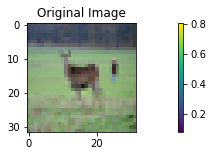

Prediction for original image: deer (99.77%)
Target class: bird


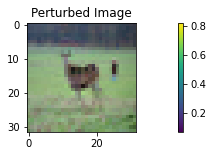

Prediction for perturbed image: bird  (98.78%)
Probability for originally predicted class: 0.20%
Values of l2_norm of perturbation: 0.6141362577343268
Success of attack: 1




In [55]:
model = CNN_CIFAR10; c = 0.1
for idx in [np.random.randint(10000)]:
  print(f'Index: {idx}') 
  x = X_test[idx];
  y_true = y_test[idx];
  classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
  print(f'True class: {classes[y_true]}')
  success_flag, x_adv, l2_norm = cw_attack_NH_version(model, x, c = c, lr_factor= lr_factor, \
                                                      max_lr = max_lr, max_iter = max_iter)
  image_results(model,x,x_adv,l2_norm,success_flag)

# Function for preparing CW-advarsarial examples

In [15]:
def CW_advarsarial_examples(model, X_test, c, max_lr, lr_factor, max_iter, starting_point, num_samples):
  
  # Create an empty numpy array to store the adversarial examples
  x_adv_stack = np.empty((0, 32, 32, 3))

  # Loop over the test data to generate the adversarial examples and stack them in the numpy array
  for i in np.arange(starting_point,starting_point+num_samples):
      if i == starting_point: print(f'Starting from {i}... ')
      if (i+1)%100 == 0:
        print(f'First {i+1} completed')
      x = X_test[i]

      # Generate the adversarial example for the current test image
      success_flag, x_adv, l2_norm = cw_attack_NH_version(model, x, c = c, lr_factor= lr_factor, \
                                                          max_lr = max_lr, max_iter = max_iter)
      
      # Stack the adversarial example in the numpy array
      x_adv_stack = np.vstack((x_adv_stack, x_adv))

  return x_adv_stack

In [16]:
c = 0.1; num_samples = 1000

# Prepare batches of adversarial examples of Linear model

**Batches of 1000 for different $c$ values**

In [25]:
model = Linear_CIFAR10
for c in np.arange(0.1,1.1,0.1):
    print(f'c value: {np.round(c,1)}')
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_Linear_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'CIFAR10_x_adv_stack_Linear_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_Linear_Lot)
      starting_point = starting_point + num_samples

Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 comple

In [26]:
stored_results = []
lot = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'CIFAR10_x_adv_stack_Linear_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('Linear')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))    
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))

    
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_CIFAR10_test_accuray',\
                                              'MLP_CIFAR10_test_accuray','CNN_CIFAR10_test_accuray'])
filename = 'Adversarial_Attacks_CIFAR10 for Linear model [CW Attack].csv'
df.to_csv(filename, index=False)
df

32/32 [==============================] - 3s 91ms/step - loss: 0.3580 - accuracy: 0.8840


,c value,Target model,avg_l2_norm,Linear_CIFAR10_test_accuray,MLP_CIFAR10_test_accuray,CNN_CIFAR10_test_accuray
0,0.1,Linear,0.19696151851493512,0.20100000500679016,0.48399999737739563,0.8880000114440918
1,0.2,Linear,0.20004210883299203,0.20100000500679016,0.48399999737739563,0.8870000243186951
2,0.3,Linear,0.2029074903620796,0.20100000500679016,0.48500001430511475,0.8870000243186951
3,0.4,Linear,0.2060369365563596,0.20100000500679016,0.4869999885559082,0.8870000243186951
4,0.5,Linear,0.2092407207499819,0.20100000500679016,0.48500001430511475,0.8859999775886536
5,0.6,Linear,0.21273093046618846,0.20100000500679016,0.4880000054836273,0.8849999904632568
6,0.7,Linear,0.21519516522463905,0.20100000500679016,0.48399999737739563,0.8859999775886536
7,0.8,Linear,0.21848675574540005,0.20100000500679016,0.48500001430511475,0.8859999775886536
8,0.9,Linear,0.2222192720638049,0.20100000500679016,0.4860000014305115,0.8849999904632568
9,1.0,Linear,0.22548643202945404,0.20100000500679016,0.48500001430511475,0.8840000033378601


Test accuracy on unperturbed data
32/32 [==============================] - 3s 78ms/step - loss: 0.3464 - accuracy: 0.8880


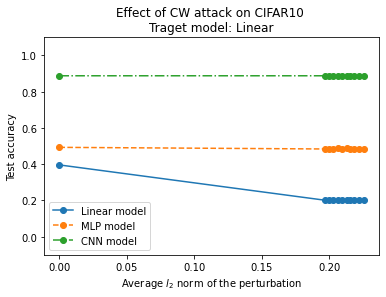

In [31]:
indexes = range(1000)
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for Linear model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])
plt.title('Effect of CW attack on CIFAR10 \nTraget model: Linear')
plt.savefig('Effect of CW attack on CIFAR10 for Linear model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 3s 88ms/step - loss: 0.3464 - accuracy: 0.8880


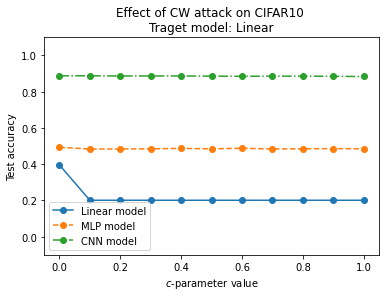

In [30]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for Linear model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('c value', ascending=True)
plt.plot(df['c value'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['c value'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['c value'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('$c$-parameter value')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])
plt.title('Effect of CW attack on CIFAR10 \nTraget model: Linear')
plt.savefig('Effect of CW attack on CIFAR10 for Linear model [c value]', dpi=600)
plt.show()

# Prepare batches of adversarial examples of MLP model

**Batches of 1000 for different $c$ values**

In [29]:
model = MLP_CIFAR10
for c in np.arange(0.1,1.1,0.1):
    print(f'c value: {np.round(c,1)}')
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_MLP_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'CIFAR10_x_adv_stack_MLP_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_MLP_Lot)
      starting_point = starting_point + num_samples

In [25]:
stored_results = []
lot = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'CIFAR10_x_adv_stack_MLP_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('MLP')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))

    
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_CIFAR10_test_accuray',\
                                              'MLP_CIFAR10_test_accuray','CNN_CIFAR10_test_accuray'])
filename = 'Adversarial_Attacks_CIFAR10 for MLP model [CW Attack].csv'
df.to_csv(filename, index=False)
df

32/32 [==============================] - 3s 92ms/step - loss: 0.4248 - accuracy: 0.8680


,c value,Target model,avg_l2_norm,Linear_CIFAR10_test_accuray,MLP_CIFAR10_test_accuray,CNN_CIFAR10_test_accuray
0,0.1,MLP,0.47539672082695583,0.28999999165534973,0.2029999941587448,0.8730000257492065
1,0.2,MLP,0.4898159446961622,0.2879999876022339,0.2070000022649765,0.8700000047683716
2,0.3,MLP,0.4994537839402653,0.28700000047683716,0.20399999618530273,0.8690000176429749
3,0.4,MLP,0.5068948751811597,0.28299999237060547,0.20399999618530273,0.8690000176429749
4,0.5,MLP,0.5140633596862468,0.2849999964237213,0.20399999618530273,0.8700000047683716
5,0.6,MLP,0.5208009288443693,0.28299999237060547,0.20399999618530273,0.8690000176429749
6,0.7,MLP,0.5307875823660052,0.2759999930858612,0.20399999618530273,0.8700000047683716
7,0.8,MLP,0.5382077647915394,0.2709999978542328,0.20399999618530273,0.8669999837875366
8,0.9,MLP,0.5486176485902545,0.27300000190734863,0.20399999618530273,0.8679999709129333
9,1.0,MLP,0.5534360250025747,0.27399998903274536,0.20399999618530273,0.8679999709129333


Test accuracy on unperturbed data
32/32 [==============================] - 3s 81ms/step - loss: 0.3464 - accuracy: 0.8880


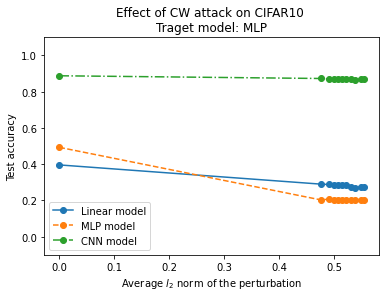

In [29]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for MLP model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on CIFAR10 \nTraget model: MLP')
plt.savefig('Effect of CW attack on CIFAR10 for MLP model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 3s 80ms/step - loss: 0.3464 - accuracy: 0.8880


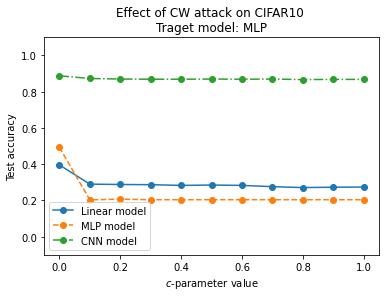

In [28]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for MLP model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('c value', ascending=True)
plt.plot(df['c value'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['c value'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['c value'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('$c$-parameter value')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on CIFAR10 \nTraget model: MLP')
plt.savefig('Effect of CW attack on CIFAR10 for MLP model [c value]', dpi=600)
plt.show()

# Prepare batches of adversarial examples of CNN model

In [20]:
model = CNN_CIFAR10
for c in np.arange(0.1,1.1,0.1):
    print(f'c value: {np.round(c,1)}')
    starting_point = 0;
    for lot in [0]:
      x_adv_stack_CNN_Lot = CW_advarsarial_examples(model, X_test, c = c, lr_factor= lr_factor, \
                                                                  max_lr = max_lr, max_iter = max_iter, \
                                                 starting_point = starting_point, num_samples = num_samples)
      filename = 'CIFAR10_x_adv_stack_CNN_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
      np.save(filename, x_adv_stack_CNN_Lot)
      starting_point = starting_point + num_samples

C value: 0.7
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
C value: 0.8
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
C value: 0.9
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed
C value: 1.0
Starting from 0... 
First 100 completed
First 200 completed
First 300 completed
First 400 completed
First 500 completed
First 600 completed
First 700 completed
First 800 completed
First 900 completed
First 1000 completed


In [27]:
stored_results = []
lot = 0
for c in np.arange(0.1,1.1,0.1):
    filename = 'CIFAR10_x_adv_stack_CNN_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
    x_adv_stack = np.load(filename)
    
    stored_results.append(np.round(c,1))
    stored_results.append('CNN')
    
    avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))
    
    if np.isnan(avg_l2_norm):
        # print(avg_l2_norm)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        indices = np.argwhere(np.isnan(delta))
        # print(indices)
        delta[indices] = 1
        x_adv_stack = X_test[:len(x_adv_stack)] + delta
        x_adv_stack = np.clip(x_adv_stack, 0, 1)
        delta = x_adv_stack-X_test[:len(x_adv_stack)]
        avg_l2_norm = np.mean(np.sqrt(np.sum((x_adv_stack-X_test[:len(x_adv_stack)])**2, axis=(1,2,3))))
        
    # print(avg_l2_norm)
    stored_results.append(avg_l2_norm)
    
    _, accuracy = Linear_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = MLP_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    _, accuracy = CNN_CIFAR10.evaluate(x_adv_stack,y_test[:len(x_adv_stack)])
    stored_results.append(accuracy)
    
stored_results = np.array(stored_results)
stored_results = stored_results.reshape(-1,6)
df = pd.DataFrame(stored_results, columns = ['c value','Target model','avg_l2_norm','Linear_CIFAR10_test_accuray',\
                                              'MLP_CIFAR10_test_accuray','CNN_CIFAR10_test_accuray'])
filename = 'Adversarial_Attacks_CIFAR10 for CNN model [CW Attack].csv'
df.to_csv(filename, index=False)
df

32/32 [==============================] - 3s 106ms/step - loss: 3.8824 - accuracy: 0.0710


,c value,Target model,avg_l2_norm,Linear_CIFAR10_test_accuray,MLP_CIFAR10_test_accuray,CNN_CIFAR10_test_accuray
0,0.1,CNN,3.2225710797874756,0.3409999907016754,0.4429999887943268,0.07100000232458115
1,0.2,CNN,4.248406332921626,0.3409999907016754,0.43299999833106995,0.07100000232458115
2,0.3,CNN,4.885302187714907,0.3149999976158142,0.4230000078678131,0.07100000232458115
3,0.4,CNN,5.281926688099801,0.31200000643730164,0.39899998903274536,0.07100000232458115
4,0.5,CNN,3.9102621306938716,0.34200000762939453,0.4449999928474426,0.07100000232458115
5,0.6,CNN,4.248406332921626,0.3409999907016754,0.43299999833106995,0.07100000232458115
6,0.7,CNN,4.447443401192919,0.3370000123977661,0.421999990940094,0.07100000232458115
7,0.8,CNN,4.684504496645344,0.32899999618530273,0.421999990940094,0.07100000232458115
8,0.9,CNN,4.8840166965970875,0.3149999976158142,0.4230000078678131,0.07100000232458115
9,1.0,CNN,5.054329274586325,0.31200000643730164,0.4230000078678131,0.07100000232458115


Test accuracy on unperturbed data
32/32 [==============================] - 3s 81ms/step - loss: 0.3464 - accuracy: 0.8880


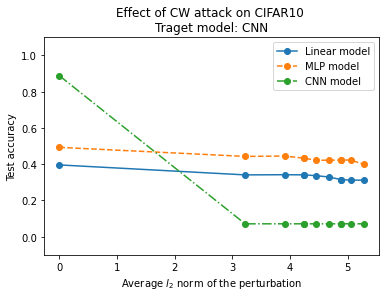

In [27]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for CNN model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = ['-', '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('avg_l2_norm', ascending=True)
plt.plot(df['avg_l2_norm'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['avg_l2_norm'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['avg_l2_norm'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('Average $l_2$ norm of the perturbation')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on CIFAR10 \nTraget model: CNN')
plt.savefig('Effect of CW attack on CIFAR10 for CNN model [l2 norm]', dpi=600)
plt.show()

Test accuracy on unperturbed data
32/32 [==============================] - 3s 78ms/step - loss: 0.3464 - accuracy: 0.8880


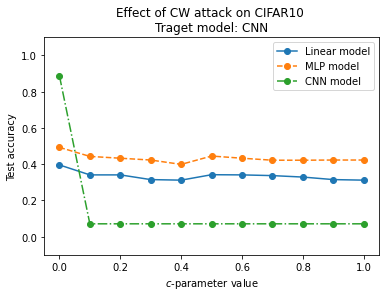

In [25]:
df = pd.read_csv('Adversarial_Attacks_CIFAR10 for CNN model [CW Attack].csv')
print('Test accuracy on unperturbed data')
_, accurcy_Linear = Linear_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_MLP = MLP_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
_, accurcy_CNN = CNN_CIFAR10.evaluate(X_test[indexes],y_test[indexes]);
# print('\n')
df.loc[10] = [0, '-', 0, accurcy_Linear, accurcy_MLP, accurcy_CNN]
df
df = df.sort_values('c value', ascending=True)
plt.plot(df['c value'],df['Linear_CIFAR10_test_accuray'],'o-')
plt.plot(df['c value'],df['MLP_CIFAR10_test_accuray'],'o--')
plt.plot(df['c value'],df['CNN_CIFAR10_test_accuray'],'o-.')
plt.xlabel('$c$-parameter value')
plt.ylabel('Test accuracy')
plt.legend(['Linear model', 'MLP model','CNN model'])
plt.ylim([-0.1,1.1])

plt.title('Effect of CW attack on CIFAR10 \nTraget model: CNN')
plt.savefig('Effect of CW attack on CIFAR10 for CNN model [c value]', dpi=600)
plt.show()

# Visualize the CW-adversarial examples

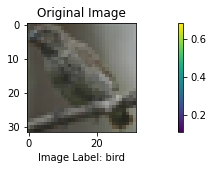

1/1 [==============================] - 0s 16ms/step


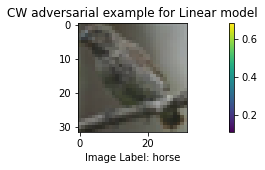

1/1 [==============================] - 0s 22ms/step


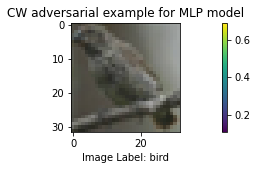

1/1 [==============================] - 0s 23ms/step


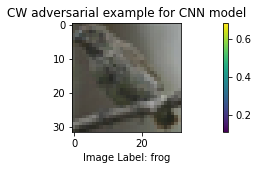

In [57]:
lot = 0; c = 0.1
filename = 'CIFAR10_x_adv_stack_Linear_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
X_test_CW_Linear = np.load(filename)
filename = 'CIFAR10_x_adv_stack_MLP_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
X_test_CW_MLP = np.load(filename)
filename = 'CIFAR10_x_adv_stack_CNN_Lot' + str(lot+1) + '_c' + str(np.round(c,1)) + '.npy'
X_test_CW_CNN = np.load(filename)


index = np.random.randint(1000)
plot_sample_image(X_test[index], y_test[index])
plt.title('Original Image'); plt.show()
plot_sample_image(X_test_CW_Linear[index], np.argmax(Linear_CIFAR10.predict(X_test_CW_Linear[index][np.newaxis, ...])))
plt.title('CW adversarial example for Linear model'); plt.show()
plot_sample_image(X_test_CW_MLP[index], np.argmax(MLP_CIFAR10.predict(X_test_CW_MLP[index][np.newaxis, ...])))
plt.title('CW adversarial example for MLP model'); plt.show()
plot_sample_image(X_test_CW_CNN[index], np.argmax(CNN_CIFAR10.predict(X_test_CW_CNN[index][np.newaxis, ...])))
plt.title('CW adversarial example for CNN model'); plt.show()